In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:1]:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/renewdata/sample_submission.csv
/kaggle/input/renewdata/test/641.png
/kaggle/input/renewdata/train/가구수정/11.png
/kaggle/input/renewdata/train/터짐/94.png
/kaggle/input/renewdata/train/들뜸/48.png
/kaggle/input/renewdata/train/피스/48.png
/kaggle/input/renewdata/train/창틀,문틀수정/11.png
/kaggle/input/renewdata/train/녹오염/11.png
/kaggle/input/renewdata/train/석고수정/48.png
/kaggle/input/renewdata/train/훼손/1231.png
/kaggle/input/renewdata/train/꼬임/173.png
/kaggle/input/renewdata/train/울음/11.png
/kaggle/input/renewdata/train/걸레받이수정/173.png
/kaggle/input/renewdata/train/틈새과다/4.png
/kaggle/input/renewdata/train/오염/173.png
/kaggle/input/renewdata/train/곰팡이/94.png
/kaggle/input/renewdata/train/이음부불량/11.png
/kaggle/input/renewdata/train/면불량/94.png
/kaggle/input/renewdata/train/반점/1.png
/kaggle/input/renewdata/train/오타공/94.png
/kaggle/input/renewdata/train/몰딩수정/94.png


## ConvNeXT 모델
https://americanoisice.tistory.com/121

In [ ]:
# !pip install timm

In [37]:
import gc
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import StratifiedKFold, train_test_split

import torch 
import torchvision as tv
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from sklearn.metrics import f1_score

from timm.data import create_transform

In [38]:

CFG = {
    'IMG_SIZE':384,
    'EPOCHS':50,
    'LEARNING_RATE':2e-4,
    'BATCH_SIZE':32,
    'SEED':42
}


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed...

In [39]:
import glob
data = pd.DataFrame({"path":glob.glob("/kaggle/input/renewdata/train/*/*")})
data

data["label"] = data["path"].apply(lambda x: x.split("/")[-2])
data

,path,label
0,/kaggle/input/renewdata/train/가구수정/11.png,가구수정
1,/kaggle/input/renewdata/train/가구수정/4.png,가구수정
2,/kaggle/input/renewdata/train/가구수정/9.png,가구수정
3,/kaggle/input/renewdata/train/가구수정/1.png,가구수정
4,/kaggle/input/renewdata/train/가구수정/2.png,가구수정
...,...,...
3452,/kaggle/input/renewdata/train/몰딩수정/19.png,몰딩수정
3453,/kaggle/input/renewdata/train/몰딩수정/110.png,몰딩수정
3454,/kaggle/input/renewdata/train/몰딩수정/26.png,몰딩수정
3455,/kaggle/input/renewdata/train/몰딩수정/79.png,몰딩수정


In [40]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data["class"] = le.fit_transform(data["label"])

In [41]:
from torch.utils.data import Dataset, DataLoader, IterableDataset

class CassavaLeafDiseaseDataset(IterableDataset):
    def __init__(self, df, transform, train_mode):
        super(CassavaLeafDiseaseDataset).__init__()
        self.df = df
        self.transform = transform
        self.start = 0
        self.end = len(df)
        self.train_mode = train_mode
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        fpath = self.df.iloc[i, 0]
        img = self.transform(Image.open(fpath).convert('RGB'))
        class_label_int = self.df.iloc[i, -1]
        return img, class_label_int
    
    ## iterable dataset 
    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:  # single-process data loading, return the full iterator
            iter_start = self.start
            iter_end = self.end
        else:  # in a worker process
            # split workload
            per_worker = int(math.ceil((self.end - self.start) / float(worker_info.num_workers))) #num_workers : 
            worker_id = worker_info.id
            iter_start = self.start + worker_id * per_worker
            iter_end = min(iter_start + per_worker, self.end)
        return map(self.__getitem__, range(iter_start, iter_end))

Iterable Dataset
https://inmoonlight.github.io/2021/02/21/PyTorch-IterableDataset/

In [42]:
import numpy as np
from sklearn.model_selection import train_test_split

df = {}
train_df, test_df = train_test_split(
    data, stratify=data.label, train_size=0.66, random_state=0
)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [44]:
datasets = {}
datasets['train'] = CassavaLeafDiseaseDataset(train_df, T.ToTensor(), True)
datasets['test'] = CassavaLeafDiseaseDataset(test_df, T.ToTensor(), True)

datasets['train'].transform = T.Compose([T.RandomHorizontalFlip(), 
                                        T.Resize((256, 256)), T.ToTensor()])
datasets['test'].transform = T.Compose([
                                        T.Resize((256, 256)), T.ToTensor()])

batch_size = 16
dataloaders = {}
dataloaders['train'] = DataLoader(datasets['train'], batch_size, num_workers=2, shuffle=False)
dataloaders['test'] = DataLoader(datasets['test'], batch_size, num_workers=2, )

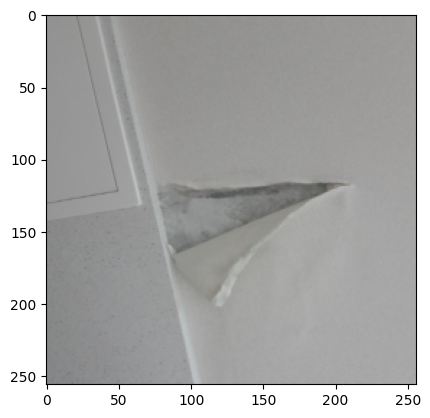

In [45]:
def show_image(data):
    img, label = data
    plt.imshow(img.permute(1, 2, 0))
    plt.show()
show_image(datasets['train'][4])

In [46]:
# datasets['train'].transform = create_transform(input_size=384, is_training=True, )#interpolation='bicubic', mean=mean, std=std
# datasets['test'].transform = create_transform(input_size=384, is_training=True, )

In [47]:
# batch_size = 16
# dataloaders = {}
# dataloaders['train'] = DataLoader(datasets['train'], batch_size, num_workers=2, pin_memory=False, shuffle=False) #shuffle=False 이유 : iterable dataset 사용시 error 발생
# dataloaders['test'] = DataLoader(datasets['test'], batch_size, num_workers=2, pin_memory=False)

In [48]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7be221cd8310>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7be221cdab00>}

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [50]:
from torchvision import models

model_ft = models.convnext_large(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Large_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
model_ft

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=192, out_features=768, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=768, out_features=192, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [52]:
# for param in model_ft.parameters():   모든 층 학습되도록 True 되어있음. False 설정 시 가중치 고정됨
#     param.requires_grad = False

n_inputs = 1536
n_outputs = 19 #클래스 개수

model_ft.classifier[2] = nn.Linear(n_inputs,n_outputs)

# for (param1, param2, param3) in zip(model_ft.classifier.parameters(), model_ft.features[7].parameters(), model_ft.avgpool.parameters()):
#     param1.requires_grad, param2.requires_grad, param3.requires_grad = True

In [53]:
model_ft = model_ft.to(device)
criterion = nn.NLLLoss() #결과가 logit , convnext 에서 주로 사용(cross entrophy와 유사)

from tqdm.notebook import tqdm
epochs = 8
lr = 0.0005
grad_clip = 1
optimizer = torch.optim.AdamW(model_ft.parameters(), lr=lr)
weight_decay = 0.001
#steps_per_epochs=64
accum_iter = 10  ## epoch 진행 중간에 learning rate 변경하는 옵션. 5로 설정 시 평가 set에대한
print_every = 10
#momentum = 0.9
alpha=0.9
def train_fine_tuning(epochs, lr, model, train_loader, test_loader, alpha,
                      devices,accum_iter, print_every, optimizer=torch.optim.Adam):
    
#     optimizer = optimizer([{'params': model.features[7].parameters()},      ##3가지 파라미터를 업데이트 하기 위함
#                            {'params': model.avgpool.parameters()},
#                            {'params': model.classifier.parameters(),
#                             'lr': lr }],
#                           lr=lr / 10, alpha=alpha)
    
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    
    total_hist = [[],[],[],[]]  
    
    # batch accumulation parameter
#     accum_iter = accum_iter  
    
    steps = 0
    running_loss = 0
    running_accuracy = 0
#     print_every = print_every
    
    for epoch in range(epochs):
        
        model.train()
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            steps += 1
                          
            images,labels = images.to(device),labels.to(device)
            
            with torch.set_grad_enabled(True):   #optional
                
                y_hat = model(images)
                loss = criterion(y_hat, labels)
                
                running_loss += loss.item()
                
                ps = torch.exp(y_hat)
                top_p, top_class = ps.topk(1, dim=1) #argmax와 유사
                equals = top_class == labels.view(*top_class.shape)
                running_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                
                
                loss = loss / accum_iter 
                
                loss.backward()
                
                if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(train_loader)):
                    optimizer.step()
                    torch.nn.utils.clip_grad_norm_(parameters=model_ft.parameters(), max_norm=1) #gradient 튐 - 안정적으로
                    optimizer.zero_grad()
                
                
                del images,labels,y_hat  #메모리 절약
                torch.cuda.empty_cache()
                
                if steps % print_every == 0:
                    test_loss = 0
                    accuracy = 0
                    with torch.no_grad():
                        model.eval()
                        for images2, labels2 in tqdm(test_loader):

                            images2, labels2 = images2.to(device),labels2.to(device)

                            y_hat2 = model(images2)
                            batch_loss = criterion(y_hat2, labels2)
                    
                            test_loss += batch_loss.item()

                            # Calculate accuracy
                            ps2 = torch.exp(y_hat2)
                            top_p2, top_class2 = ps2.topk(1, dim=1)
                            equals2 = top_class2 == labels2.view(*top_class2.shape)
                            accuracy += torch.mean(equals2.type(torch.FloatTensor)).item()
                            
                            del images2,labels2,y_hat2
                            torch.cuda.empty_cache()
                    
                    train_loss = running_loss/print_every
                    train_accuracy = running_accuracy/print_every
                    test_loss = test_loss/len(test_loader)
                    test_accuracy = accuracy/len(test_loader)
                    total_hist[0].append(train_loss)
                    total_hist[1].append(train_accuracy)
                    total_hist[2].append(test_loss)
                    total_hist[3].append(test_accuracy)
                    
                    print(f"Epoch {epoch+1}/{epochs}.. "
                          f"Train loss: {train_loss:.3f}.. "
                          f"Test loss: {test_loss:.3f}.. "
                          f"Test accuracy: {test_accuracy:.3f}")
                    running_loss = 0
                    running_accuracy = 0
                    model.train()
                    
                    sched.step(test_loss)
                
        torch.cuda.empty_cache()
        gc.collect()
        
                                      
    train_total_loss = np.array(total_hist[0])
    train_total_acc = np.array(total_hist[1])
    
    val_total_loss = np.array(total_hist[2])   
    val_total_acc = np.array(total_hist[3])
    
    
    total = {'train_loss': train_total_loss, 'train_acc': train_total_acc,
               'val_loss': val_total_loss, 'val_acc': val_total_acc}
    
    return pd.DataFrame({'Train Loss':total_hist[0], 'Train Accuracy':total_hist[1],
                         'Val Loss':total_hist[2], 'Val Accuracy':total_hist[3]})



## 속도 개선
1. model : convnext tiny
2. optimizer : RMSprop
3. fine tuning 장점 : 전체를 학습하기 보다 부분 레이어 학습.어느정도 점수까지는 빨리 도달 / 단점 : 깊게 학습하지 못함. 모든 층을 학습할 수 없다

In [54]:
history2 = train_fine_tuning(epochs, lr, model_ft, dataloaders['train'], dataloaders['test'],
                             weight_decay, device, accum_iter, print_every, optimizer)

  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 0.001.. Test loss: -1.172.. Test accuracy: 0.406


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: -1.097.. Test loss: -2.152.. Test accuracy: 0.406


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: -2.060.. Test loss: -3.015.. Test accuracy: 0.406


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: -2.743.. Test loss: -3.557.. Test accuracy: 0.406


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: -3.652.. Test loss: -4.064.. Test accuracy: 0.406


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: -4.074.. Test loss: -4.439.. Test accuracy: 0.406


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: -4.385.. Test loss: -4.816.. Test accuracy: 0.406


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: -4.875.. Test loss: -5.158.. Test accuracy: 0.406


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: -5.120.. Test loss: -5.495.. Test accuracy: 0.406


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: -5.716.. Test loss: -5.811.. Test accuracy: 0.406


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: -5.553.. Test loss: -6.111.. Test accuracy: 0.406


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: -5.931.. Test loss: -6.425.. Test accuracy: 0.410


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: -6.640.. Test loss: -6.725.. Test accuracy: 0.416


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: -6.258.. Test loss: -7.034.. Test accuracy: 0.436


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 2/8.. Train loss: -6.395.. Test loss: -7.320.. Test accuracy: 0.449


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 2/8.. Train loss: -7.468.. Test loss: -7.641.. Test accuracy: 0.492


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 2/8.. Train loss: -8.088.. Test loss: -7.939.. Test accuracy: 0.514


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 2/8.. Train loss: -7.846.. Test loss: -8.279.. Test accuracy: 0.521


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 2/8.. Train loss: -8.588.. Test loss: -8.621.. Test accuracy: 0.520


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 2/8.. Train loss: -8.759.. Test loss: -8.926.. Test accuracy: 0.490


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 2/8.. Train loss: -9.054.. Test loss: -9.270.. Test accuracy: 0.500


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 2/8.. Train loss: -9.921.. Test loss: -9.637.. Test accuracy: 0.517


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 2/8.. Train loss: -9.547.. Test loss: -9.969.. Test accuracy: 0.532


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 2/8.. Train loss: -9.984.. Test loss: -10.278.. Test accuracy: 0.526


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 2/8.. Train loss: -10.398.. Test loss: -10.628.. Test accuracy: 0.528


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 2/8.. Train loss: -10.762.. Test loss: -10.933.. Test accuracy: 0.530


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 2/8.. Train loss: -11.072.. Test loss: -11.268.. Test accuracy: 0.568


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 2/8.. Train loss: -11.279.. Test loss: -11.541.. Test accuracy: 0.530


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 3/8.. Train loss: -10.991.. Test loss: -11.925.. Test accuracy: 0.542


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 3/8.. Train loss: -11.776.. Test loss: -12.523.. Test accuracy: 0.575


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 3/8.. Train loss: -13.008.. Test loss: -12.871.. Test accuracy: 0.589


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 3/8.. Train loss: -12.793.. Test loss: -13.133.. Test accuracy: 0.597


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 3/8.. Train loss: -13.093.. Test loss: -13.491.. Test accuracy: 0.621


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 3/8.. Train loss: -13.820.. Test loss: -13.850.. Test accuracy: 0.609


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 3/8.. Train loss: -13.962.. Test loss: -14.151.. Test accuracy: 0.591


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 3/8.. Train loss: -14.500.. Test loss: -14.482.. Test accuracy: 0.591


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 3/8.. Train loss: -14.623.. Test loss: -14.884.. Test accuracy: 0.609


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 3/8.. Train loss: -14.749.. Test loss: -15.254.. Test accuracy: 0.608


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 3/8.. Train loss: -15.467.. Test loss: -15.581.. Test accuracy: 0.617


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 3/8.. Train loss: -15.530.. Test loss: -15.899.. Test accuracy: 0.634


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 3/8.. Train loss: -16.041.. Test loss: -16.251.. Test accuracy: 0.638


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 3/8.. Train loss: -16.298.. Test loss: -16.632.. Test accuracy: 0.600


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 3/8.. Train loss: -16.247.. Test loss: -17.040.. Test accuracy: 0.625


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 4/8.. Train loss: -16.530.. Test loss: -17.361.. Test accuracy: 0.649


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 4/8.. Train loss: -17.914.. Test loss: -17.654.. Test accuracy: 0.656


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 4/8.. Train loss: -18.267.. Test loss: -17.996.. Test accuracy: 0.647


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 4/8.. Train loss: -18.200.. Test loss: -18.389.. Test accuracy: 0.648


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 4/8.. Train loss: -19.124.. Test loss: -18.777.. Test accuracy: 0.660


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 4/8.. Train loss: -19.204.. Test loss: -19.136.. Test accuracy: 0.649


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 4/8.. Train loss: -19.730.. Test loss: -19.504.. Test accuracy: 0.657


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 4/8.. Train loss: -20.154.. Test loss: -19.908.. Test accuracy: 0.679


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 4/8.. Train loss: -20.015.. Test loss: -20.243.. Test accuracy: 0.668


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 4/8.. Train loss: -20.765.. Test loss: -20.587.. Test accuracy: 0.635


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 4/8.. Train loss: -20.777.. Test loss: -20.972.. Test accuracy: 0.621


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 4/8.. Train loss: -21.503.. Test loss: -21.384.. Test accuracy: 0.645


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 4/8.. Train loss: -21.616.. Test loss: -21.707.. Test accuracy: 0.669


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 4/8.. Train loss: -22.010.. Test loss: -22.156.. Test accuracy: 0.665


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 5/8.. Train loss: -21.848.. Test loss: -22.892.. Test accuracy: 0.620


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 5/8.. Train loss: -23.154.. Test loss: -23.238.. Test accuracy: 0.621


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 5/8.. Train loss: -24.105.. Test loss: -23.605.. Test accuracy: 0.639


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 5/8.. Train loss: -23.662.. Test loss: -24.061.. Test accuracy: 0.644


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 5/8.. Train loss: -24.215.. Test loss: -24.453.. Test accuracy: 0.645


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 5/8.. Train loss: -25.342.. Test loss: -24.861.. Test accuracy: 0.626


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 5/8.. Train loss: -25.071.. Test loss: -25.271.. Test accuracy: 0.614


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 5/8.. Train loss: -26.308.. Test loss: -25.716.. Test accuracy: 0.644


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 5/8.. Train loss: -25.546.. Test loss: -26.122.. Test accuracy: 0.678


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 5/8.. Train loss: -26.594.. Test loss: -26.536.. Test accuracy: 0.675


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 5/8.. Train loss: -27.131.. Test loss: -26.980.. Test accuracy: 0.652


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 5/8.. Train loss: -26.978.. Test loss: -27.410.. Test accuracy: 0.642


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 5/8.. Train loss: -27.946.. Test loss: -27.828.. Test accuracy: 0.659


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 5/8.. Train loss: -27.983.. Test loss: -28.278.. Test accuracy: 0.675


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 5/8.. Train loss: -28.305.. Test loss: -29.143.. Test accuracy: 0.631


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 6/8.. Train loss: -28.806.. Test loss: -29.589.. Test accuracy: 0.597


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 6/8.. Train loss: -29.987.. Test loss: -30.039.. Test accuracy: 0.595


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 6/8.. Train loss: -30.316.. Test loss: -30.383.. Test accuracy: 0.639


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 6/8.. Train loss: -30.405.. Test loss: -30.790.. Test accuracy: 0.655


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 6/8.. Train loss: -31.515.. Test loss: -31.329.. Test accuracy: 0.657


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 6/8.. Train loss: -31.821.. Test loss: -31.731.. Test accuracy: 0.655


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 6/8.. Train loss: -32.178.. Test loss: -32.150.. Test accuracy: 0.660


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 6/8.. Train loss: -32.458.. Test loss: -32.628.. Test accuracy: 0.678


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 6/8.. Train loss: -32.987.. Test loss: -33.123.. Test accuracy: 0.683


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 6/8.. Train loss: -33.613.. Test loss: -33.603.. Test accuracy: 0.649


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 6/8.. Train loss: -33.389.. Test loss: -34.055.. Test accuracy: 0.557


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 6/8.. Train loss: -34.158.. Test loss: -34.516.. Test accuracy: 0.550


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 6/8.. Train loss: -35.350.. Test loss: -35.028.. Test accuracy: 0.572


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 6/8.. Train loss: -34.726.. Test loss: -35.491.. Test accuracy: 0.633


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 7/8.. Train loss: -34.816.. Test loss: -35.823.. Test accuracy: 0.672


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 7/8.. Train loss: -36.539.. Test loss: -36.375.. Test accuracy: 0.671


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 7/8.. Train loss: -37.598.. Test loss: -36.880.. Test accuracy: 0.644


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 7/8.. Train loss: -37.024.. Test loss: -37.287.. Test accuracy: 0.585


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 7/8.. Train loss: -38.401.. Test loss: -37.769.. Test accuracy: 0.553


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 7/8.. Train loss: -38.472.. Test loss: -38.285.. Test accuracy: 0.559


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 7/8.. Train loss: -38.956.. Test loss: -38.779.. Test accuracy: 0.588


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 7/8.. Train loss: -40.360.. Test loss: -39.302.. Test accuracy: 0.625


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 7/8.. Train loss: -39.514.. Test loss: -39.780.. Test accuracy: 0.638


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 7/8.. Train loss: -40.285.. Test loss: -40.270.. Test accuracy: 0.618


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 7/8.. Train loss: -40.835.. Test loss: -40.649.. Test accuracy: 0.609


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 7/8.. Train loss: -41.367.. Test loss: -41.390.. Test accuracy: 0.623


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 7/8.. Train loss: -42.174.. Test loss: -41.804.. Test accuracy: 0.632


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 7/8.. Train loss: -42.541.. Test loss: -42.148.. Test accuracy: 0.621


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 8/8.. Train loss: -42.401.. Test loss: -43.058.. Test accuracy: 0.519


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 8/8.. Train loss: -43.374.. Test loss: -43.673.. Test accuracy: 0.515


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 8/8.. Train loss: -45.005.. Test loss: -44.355.. Test accuracy: 0.539


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 8/8.. Train loss: -44.422.. Test loss: -44.823.. Test accuracy: 0.558


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 8/8.. Train loss: -45.274.. Test loss: -45.241.. Test accuracy: 0.605


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 8/8.. Train loss: -46.439.. Test loss: -45.953.. Test accuracy: 0.603


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 8/8.. Train loss: -46.905.. Test loss: -46.558.. Test accuracy: 0.568


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 8/8.. Train loss: -47.527.. Test loss: -47.080.. Test accuracy: 0.545


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 8/8.. Train loss: -47.632.. Test loss: -47.664.. Test accuracy: 0.553


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 8/8.. Train loss: -47.731.. Test loss: -48.214.. Test accuracy: 0.572


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 8/8.. Train loss: -49.153.. Test loss: -48.818.. Test accuracy: 0.569


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 8/8.. Train loss: -49.445.. Test loss: -49.375.. Test accuracy: 0.584


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 8/8.. Train loss: -49.807.. Test loss: -49.972.. Test accuracy: 0.632


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 8/8.. Train loss: -50.690.. Test loss: -50.519.. Test accuracy: 0.648


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 8/8.. Train loss: -50.617.. Test loss: -51.132.. Test accuracy: 0.633


In [1]:
final_test = pd.DataFrame({"path" : sorted(glob.glob("/kaggle/input/renewdata/test/*"))})
final_test["label"] = np.nan


batch_size = 4
datasets['final_test'] = CustomDataset(final_test, T.ToTensor(), False)
datasets['final_test'].transform = T.Compose([T.Resize((256,256)), T.ToTensor()]) #T.CenterCrop(size=(256, 256)),


dataloaders['final_test'] = DataLoader(datasets['final_test'], batch_size, num_workers=2, pin_memory=False, shuffle=False)

images,labels = [],[]
pred = []

for images, labels in tqdm(dataloaders['final_test']):
    images = images.to(device)
    labels = labels.to(device)
    result = model_ft(images)
    
    pred += result.argmax(1).detach().cpu().numpy().tolist()
    
sub = pd.read_csv("/kaggle/input/renewdata/sample_submission.csv")
sub

sub["label"] = le.inverse_transform(pred)

NameError: name 'pd' is not defined

###과제
데이터추가/ 교차검증 / 제출

모델 뒷부분 Fine tuning

In [ ]:
# def train(model, optimizer, train_loader, val_loader, scheduler, device):
#     model.to(device)
#     criterion = nn.CrossEntropyLoss().to(device)
    
#     best_score = 0
#     best_model = None
#     num_patience = 4
#     cur_patience = 0
#     for epoch in range(1, CFG['EPOCHS']+1):
#         model.train()
#         train_loss = []
#         for imgs, labels in tqdm(iter(train_loader)):
#             imgs = imgs.float().to(device)
#             labels = labels.to(device)
            
#             optimizer.zero_grad()
            
#             output = model(imgs)
#             loss = criterion(output, labels)
            
#             loss.backward()
#             optimizer.step()
            
#             train_loss.append(loss.item())
                    
#         _val_loss, _val_score = validation(model, criterion, val_loader, device)
#         _train_loss = np.mean(train_loss)
#         print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Weighted F1 Score : [{_val_score:.5f}]')
       
#         if scheduler is not None:
#             scheduler.step(_val_score)
            
#         if best_score < _val_score:
#             best_score = _val_score
#             best_model = model
#             cur_patience = 0
#         else :
#             cur_patience+=1
#             print(cur_patience)
#             if cur_patience>=num_patience:
#                 break
#     return best_model

# def validation(model, criterion, val_loader, device):
#     model.eval()
#     val_loss = []
#     preds = []
#     true_labels = []
#     with torch.no_grad():
#         for imgs, labels in tqdm(iter(val_loader)):
#             imgs = imgs.float().to(device)
#             labels = labels.to(device)
            
#             pred = model(imgs)
            
#             loss = criterion(pred, labels)
            
#             preds += pred.argmax(1).detach().cpu().numpy().tolist()
#             true_labels += labels.detach().cpu().numpy().tolist()
            
#             val_loss.append(loss.item())
        
#         _val_loss = np.mean(val_loss)
#         _val_score = f1_score(true_labels, preds, average='weighted')
    
#     return _val_loss, _val_score

# def inference(model, test_loader, device):
#     model.eval()
#     preds = []
#     with torch.no_grad():
#         for imgs in tqdm(iter(test_loader)):
#             imgs = imgs.float().to(device)
            
#             pred = model(imgs)
            
#             preds += pred.argmax(1).detach().cpu().numpy().tolist()
    
#     preds = le.inverse_transform(preds)  ## 앙상블 할땐 확률값 반환
#     return preds


# from sklearn.model_selection import StratifiedKFold
# skf = StratifiedKFold(n_splits = 3, shuffle=True, random_state = 45) ## n_splits >= 5

# test = pd.read_csv('/kaggle/input/renewdata/test.csv')
# test["img_path"] = "/kaggle/input/renewdata" + test["img_path"].str[1:]

# result = []
# for train_index, valid_index in skf.split(train_df, train_df["label"]):
#     x_train = train_df.iloc[train_index]
#     x_valid = train_df.iloc[valid_index]
#     train_dataset = CassavaLeafDiseaseDataset(x_train['path'].values, x_train['label'].values, create_transform(input_size=384, is_training=True, ))
#     train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

#     val_dataset = CassavaLeafDiseaseDataset(x_valid['path'].values, x_valid['label'].values, test_transform)
#     val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)
    
    
#     model = model_ft
#     model.eval()
#     optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=3, threshold_mode='abs', min_lr=1e-8, verbose=True)

#     infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)
    

#     test_dataset = CustomDataset(test['img_path'].values, None, test_transform)
#     test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)
    
#     preds = inference(infer_model, test_loader, device)
#     result.append(preds)

In [ ]:
train_df